### Demonstration of an evaluation based on the MCTSAgent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import chess
import chess.variant
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../../../')
from DeepCrazyhouse.src.runtime.ColorLogger import enable_color_logging
from DeepCrazyhouse.src.domain.agent.NeuralNetAPI import NeuralNetAPI
from DeepCrazyhouse.src.domain.agent.player.MCTSAgent import MCTSAgent
from DeepCrazyhouse.src.domain.agent.player.RawNetAgent import RawNetAgent
from DeepCrazyhouse.src.domain.crazyhouse.GameState import GameState
from DeepCrazyhouse.src.runtime.ColorLogger import enable_color_logging
from time import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')
enable_color_logging()

In [4]:
batch_size = 16 #1 #8

In [5]:
nets = []
for idx in range(2):
    nets.append(NeuralNetAPI(ctx='gpu', batch_size=batch_size))

self.symbol_path: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/model/symbol/model-1.25948-0.589-symbol.json
self.params_path: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/model/params/model-1.25948-0.589-0246.params
self.symbol_path: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/model/symbol/model-1.25948-0.589-symbol.json
self.params_path: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/model/params/model-1.25948-0.589-0246.params


In [6]:
raw_agent = RawNetAgent(nets[0])

In [7]:
mcts_agent = MCTSAgent(nets, threads=16, playouts_empty_pockets=4096*5, playouts_filled_pockets=4096*5,
                 cpuct=2.5, dirichlet_epsilon=.25, dirichlet_alpha=0.2, batch_size=batch_size, q_value_weight=0.7,
                 max_search_depth=40, temperature=0., virtual_loss=3, verbose=True,
                 min_movetime=15000, check_mate_in_one=False, use_oscillating_cpuct=False, use_pruning=True)

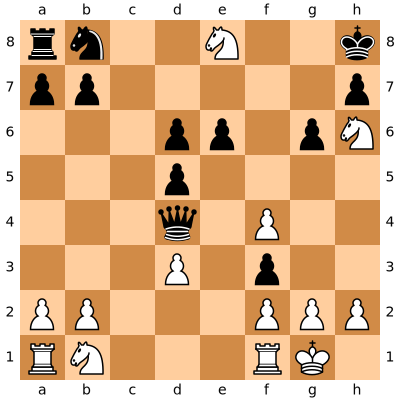

In [8]:
board = chess.variant.CrazyhouseBoard()

#board.push_uci('e2e4')
#board.push_uci('e7e6')

fen = 'rnbqkb1r/ppp1pppp/5n2/3P4/8/8/PPPP1PPP/RNBQKBNR/P w KQkq - 1 3'
fen = 'rnb2rk1/p3bppp/2p5/3p2P1/4n3/8/PPPPBPPP/RNB1K1NR/QPPq w KQ - 0 11'
#fen = 'r1b1kbnr/ppp1pppp/2n5/3q4/3P4/8/PPP1NPPP/RNBQKB1R/Pp b KQkq - 1 4'
#fen = 'r1b1k2r/ppp2ppp/2n5/3np3/3P4/2PBP3/PpPB1PPP/1Q2K1NR/QNrb b Kkq - 27 14'
#fen = 'r1bb4/ppp2pkp/5npb/4p3/4P3/2N5/PPP1BPPP/3RK2R/QNRqpnp w K - 3 16'
#fen = '3R1b2/1bP1kp2/3Npn1p/3p4/5p2/5N1b/PPP2P1P/5Q1K/RPRPRQPnpbp b - - 4 36'
#fen = 'r3k1nr/ppp2ppp/2n5/8/q7/Pp6/1PnRN1PP/1K3B1R/BBQBppppp b kq - 3 27'
#fen = 'rn2N2k/pp5p/3pp1pN/3p4/3q1P2/3P1p2/PP3PPP/RN3RK1/Qrbbpbb b - - 0 27'
#fen = 'rn2N2k/pp5p/3pp1pN/3p4/3q1P2/3P1p2/PP3PPP/RN3RK1/Qrbbpbb b - - 0 30'
#fen = 'rn2N2k/pp5p/3pp1pN/3p4/5P2/3P1p2/PP3RPP/RN4K1/QQprbbpbb b - - 1 30'

# Test positions
#fen = '3R1b2/1bP1kp2/3Npn1p/3p4/5p2/5N1b/PPP1QP1P/3R1RK1/QPpprnpbp b - - 0 29'
fen = 'rn2N2k/pp5p/3pp1pN/3p4/3q1P2/3P1p2/PP3PPP/RN3RK1[Qrbbpbb] b - - 3 30'
#fen = 'q6r/p2P1pkp/1p1b1n2/2p2B2/8/6n1/PPP2KPp/R4R2/PNNRPBPbqpp w - - 2 26'
#fen ='2kr1b2/1bp2p1p/p3pP1p/1p5Q/5B2/3B1p2/PPP2PrP/R4R1K/QNpnnnp w - - 0 18'
#fen = 'q6r/p2P1pkp/1p1b1n2/2p2B2/8/6n1/PPP2KPp/R4R2/PNNRPBPbqpp w - - 50 26'
#fen = 'r4r1k/ppp1q1bp/4Ppp1/1P6/2NN3P/2BPPb2/P2PNPpR/R3K3/PBQn b Q - 2 34'
#fen = 'r1bq1b1r/ppp1kPpp/4Pn2/n2Pp3/2B4n/3P4/PPP2PPP/RNBQK2R/ w KQ - 0 10'

#fen = 'r4rk1/ppp2pbp/1nnp4/6P1/4Pp2/1P1P1N1P/2P2PPK/R2Q1R2/QNbbpb w - - 0 23'
#fen = 'r4rk1/ppp2pPp/1nn3nP/4b3/5p1B/1P1P3P/2P2PPK/R2Q1R2/Qbpnpb w - - 2 37'
#fen = 'r4rk1/ppp2pPp/1nn2bnP/4b3/6Q1/1P1P1pBP/2P2PPK/R4R2/Qpnpb w - - 2 39'
#fen = 'B2q1r1k/p3pp2/6pb/3pB2p/3N4/B2NP1pn/P1PP2P1/R2Q3K/PPrnprp b - - 0 28'
#fen = 'r1bq3r/p1ppbkpp/2p2n2/8/4P3/8/PPP2PPP/RNBQK2R/NPPnbp w KQ - 2 8'
#fen = 'r1bqk2r/1pp1nppp/1p3p2/3p4/3P3n/1B6/PP2BPPP/RNBQ1KNR/Pp b kq - 0 14'
#fen = '3qk2r/1pp1nppp/1p3p2/3p4/3P3n/1B5P/RP2BPpP/1NBQ2KR/RBPPn b k - 2 18'
#fen = 'r2q2kb/ppp4p/1nn1P1p1/4p1N1/2Pb4/1P1P2NP/2PB1rP1/Q4RK1/RPppb w - - 0 27'
#fen = 'r1bqk1r1/ppppbppp/5n2/4nN2/2B1P3/2N5/PPP2PPP/R1BQK2R/Pp w KQq - 2 8'
#fen = 'r2q1rk1/pP2ppbp/2p3pb/2Q5/4Pp2/2NB1NpP/PPP3P1/R4RK1/NBpn b - - 0 19'
#fen = 'r1bqkb1r/ppp1pppp/2n2n2/3p4/3P4/2N2N2/PPP1PPPP/R1BQKB1R/ w KQkq - 6 4'
#fen = 'r1bq1b2/2p1pk2/p1p2npp/8/3P4/P4N2/1PP2PPP/R1B1K2R/RPNPbnqp w KQ - 26 0'
#fen = 'r5k1/ppp2Rp1/1bnp1qP1/2b1pP2/8/3P1N1p/PPP2PPP/R2Q1R1K/Nbbn w - - 42 0'
#fen = 'r2q3r/ppp1k1pp/2npN3/2b1p3/4P1n1/2NP4/PPP2PPP/R1B2RK1/BPqb w - - 0 11'
#fen = 'r2qk1r1/ppp2p2/2np3p/2bBp1p1/4P1bn/3P1NB1/PPP2PPP/R2Q1RK1/N w q - 0 12'
#fen = 'r2k3r/pppb2pp/5b2/6N1/4P2n/3Q4/PPP2PPP/R1B1K2R/PPNPqbnp w KQ - 0 14'
#fen = 'r1bqk2r/ppp1bppp/5n2/3p4/2BQP3/2N5/PPP2PPP/R1B1K2R/NPnp w KQkq - 0 8'
#fen = '3r1rk1/p1p1npp1/2pp3p/2b1p1NQ/4P3/3P1P2/PPP2P1P/R2Q1RK1/BBnbn w - - 2 18'
#fen = 'r2q1rk1/p1p1bpp1/2pp1n1p/2b1pN2/4P1nB/3P1N2/PPP2PPP/R2Q1RK1/B w - - 0 13'
#fen = 'r1bq1rk1/ppp2pp1/2np1n1p/2b1p1B1/2B1P3/2NP1N2/PPP2PPP/R2Q1RK1/ w - - 14 8'
#fen = 'r1bqk1r1/pppp1ppp/2n2n2/5N2/1bB1P3/2N4p/PPP2PPP/R1BQK1R1/P w Qq - 2 9'
#fen = 'r1bqk1r1/ppp2ppp/2n2n2/3p1N2/1bB1P3/2N4P/PPP2P1P/R1BQK1R1/PP w Qq - 0 10'
#fen = 'r1bqk2r/ppppbppp/2n2n2/8/2BNP3/8/PPP2PPP/RNBQK2R/Pp w KQkq - 1 6'
#fen = 'r1b1k1r1/pp1p1ppp/1q1B1nn1/1B3N2/4P3/2P1p3/P1P1QPpP/R3K1R1/BPPn w Qq - 34 18'
#fen = 'r1bqk3/ppp1bprp/3p1n2/5PP1/4P2n/2NQ4/PPP2PBP/R1B1K2R/Npp w KQq - 1 13'
#fen = 'r1bqk1nr/pppp1ppp/5b2/4nNP1/2B1P3/7p/PPP2PPP/RNBQK2R/ w KQkq - 1 8'
#fen = 'r1b1k1nr/ppp2ppp/5q2/3pnN2/4P3/7p/PPP2PPP/RNBQKB1R/Bp w KQkq - 1 10'
#fen = 'r3k2r/ppp2ppp/5n2/3pnb2/4P3/7p/PPP2PPP/RNBQKB1R/Qbnp w KQkq - 22 12'
#fen = 'rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR/ w KQkq - 2 2'
#fen = 'r1bq1rk1/ppp2ppp/2np4/2bBp3/4P1n1/3P1N2/PPP1QPPP/R1B2RK1/N w - - 2 10'
#fen = 'r1bq1rk1/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP1N2/PPP2PPP/R1BQ1RK1/ w - - 12 7'
#fen = 'r1bq1rk1/pppp1ppp/2n5/2bBp3/4P1n1/3P1N2/PPP2PPP/R1BQ1RK1/N w - - 2 9'
#fen = 'r1bqk1r1/ppppbppp/5n2/1B2nN2/4P3/2N4p/PPP2PPP/R1BQK2R/P w KQq - 16 9'
#fen = 'r1bqkb1r/ppp2ppp/3p4/6P1/4n3/2N5/PPP2P1P/R1BQK1Rb/NPNpp w Qkq - 2 13'

#fen = 'r1b1kb1r/p1p1pppp/2N5/1B2N3/2pPn3/2PKB3/P1PP2p1/3q1rR1/QPPNP w - - 0 25' # mate threat
#fen = 'r1b1kb1r/p1p1pppp/2N5/4N3/2BPn3/2PKB3/P1PP2p1/3q1rR1/PQPPNP b - - 0 25'
#fen = 'r1b1kb1r/p1p1pppp/2N5/1B6/2NPn3/2PKB3/P1PP2p1/3q1rR1/PQPPNP b - - 1 25'
#fen = '3rkb1r/2pb1pp1/q2Pp3/3pP2p/3P4/2PPnP2/P1P1N1PP/R2R2K1/NNQbb b k - 0 21' # mate threat

# previous stalled connection fen
#fen = 'r1bk3r/ppppbpQp/4p3/8/4n3/4P2N/PPPP2PP/R1Bq1BKR/PNNp b - - 2 13'
#fen = 'r1bqkbnr/ppp2ppp/3p4/8/3QP3/2N4p/PPP2PPP/R1B1KB1R/PNn w KQkq - 1 7'
#fen = 'r1bq1rk1/ppp2pp1/2np1n1p/2b1p1B1/2B1P3/2NP1N2/PPP2PPP/R2Q1RK1/ w - - 14 8'
#fen = 'rnb1kb1r/ppp1pppp/5n2/q7/8/2N2N2/PPPP1PPP/R1BQKB1R/Pp w KQkq - 0 5'
#fen = 'rnb2b1r/ppp1pkpp/5n2/2q5/3N2p1/2N5/PPPP1PPP/R1BQK2R/PPb w KQ - 0 8'
board.set_fen(fen)
#board = board.mirror()

state = GameState(board)
board

In [9]:
chess.COLOR_NAMES

['black', 'white']

In [10]:
board.turn

False

In [11]:
len(list(state.get_legal_moves()))

134

In [12]:
def plot_moves_with_prob(moves, probs, only_top_x=None):
    
    # revert the ordering afterwards
    idx_order = np.argsort(probs)[::-1]
    
    if only_top_x is not None and only_top_x < len(idx_order):
        idx_order = idx_order[:only_top_x]
    
    #moves_ordered = moves[range(len(moves))] #idx_order[::-1]]
    probs_ordered = [] #probs[idx_order]
    
    moves_ordered = []
    for idx in idx_order:
        probs_ordered.append(probs[idx])
        moves_ordered.append(moves[idx])
        
    plt.barh(range(len(probs_ordered)), probs_ordered)
    plt.yticks(range(len(moves_ordered)), moves_ordered)


### Evalution using the raw network

In [13]:
t_s = time()
pred_value, legal_moves, p_vec_small, cp, depth, nodes, time_elapsed_s, nps, pv = raw_agent.evaluate_board_state(state)
print('Elapsed time: %.4fs' % (time()-t_s))

Elapsed time: 0.1042s


2019-01-11 01:08:54 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:08:54 matplotlib.font_manager[21494] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Liberation Sans ('/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf') with score of 2.050000.
2019-01-11 01:08:55 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:08:55 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:08:55 matplotlib.axes._base[21494] DEBUG update_title_pos


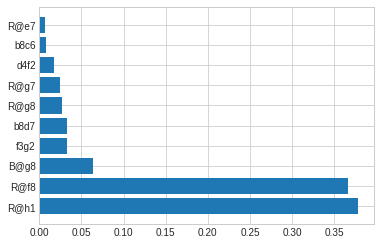

In [14]:
plot_moves_with_prob(legal_moves, p_vec_small, only_top_x=10)

### Evalution using the MCTS-Agent

In [15]:
t_s = time()
pred_value, legal_moves, p_vec_small, cp, depth, nodes, time_elapsed_s, nps, pv = mcts_agent.evaluate_board_state(state)
print('Elapsed time: %.4fs' % (time()-t_s))

start inference thread...
self.thread_inference.isAlive() True
start inference thread...
self.thread_inference.isAlive() True
2019-01-11 01:08:55 root[21494] DEBUG Starting a brand new search tree...
info score cp -9999 depth 4 nodes 161 pv R@f8 Q@g8 f8g8 h6f7
2019-01-11 01:08:55 root[21494] DEBUG Update info
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.92
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: h6f7 0.97
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.91
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.88
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: h6f7 0.70
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.91
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.48
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.87
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: f1f2 0.89
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g8 0.94
2019-01-11 01:08:55 root[21494] DEBUG Threat Move: Q@g7 0.59
2019-01-11 01:08:5

2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: h6f7 0.97
2019-01-11 01:08:56 root[21494] DEBUG Threat move idx update h6f7
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: h6f7 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: h6f7 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g7 1.00
2019-01-11 01:08:56 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:56

2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g7 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: h6f7 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:57 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:57 root

2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: h6f7 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8 1.00
info score cp -261 depth 12 nodes 945 pv B@g8 Q@h3 P@e2 b1d2 e2f1q a1f1 f3g2 h3g2 P@e2 P@g7 d4g7 e8g7
2019-01-11 01:08:58 root[21494] DEBUG Update info
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:08:58 root[21494] DEBUG Threat Move: Q@g8

2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g7 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:00 root[21494] DEBUG Threat Move: Q@g8 1.00
info score cp -9999 depth 2 nodes 1345 pv R@f7 Q@g8
2019-01-11 01:09:00 root[21494] D

2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g7 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root

2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: h6f7 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:01 root[21494] DEBUG Threat Move: Q@f8 1.00
2019-01-11 01:09:01 root

2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:02 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:02 root

2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: g1f2 0.10
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: Q@g7 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: Q@g8 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: g1f2 0.10
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root[21494] DEBUG Threat Move: f1f2 1.00
2019-01-11 01:09:03 root

In [16]:
mcts_agent.root_node.legal_moves[mcts_agent.root_node.n.argmax()]

Move.from_uci('B@g8')

In [17]:
mcts_agent.root_node.legal_moves[mcts_agent.root_node.q.argmax()]

Move.from_uci('B@g8')

In [18]:
b  = (mcts_agent.root_node.q + 1) * .5
#b /= b.sum()

In [19]:
a = mcts_agent.root_node.n / mcts_agent.root_node.n.sum()

In [20]:
#c = (a * b ) + (0.3 * a + 0.7 * b)

In [21]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [22]:
most_visit = mcts_agent.root_node.n.argmax()

#for node in enumerate(mcts_agent.root_node.child_nodes):
#    if node is None:
#        b[i] = 0
        
#if mcts_agent.root_node.q[most_visit] > 0:
#c = (0.65 * a + 0.35 * b)

#else: 
thresh_idces = a < a.max() * .5 #25
b /= b.sum()
b[thresh_idces] = 0
#b /= 3
c = 0.2 * a + 0.8 * b
a_sorted = np.sort(a)[::-1]
#a_sorted *= a_sorted
#percentile = a_sorted[0] - a_sorted[1]
#percentile = sigmoid(a_sorted[0] - a_sorted[1]) * (1 + sigmoid(a_sorted[0] - a_sorted[1])) * 100
#percentile = (1 - (percentile)) * 100
#percentile -= (a_sorted[2]) * 100
#thresh_idces = a < np.percentile(a, percentile) #np.median(a)

c /= c.sum()

In [23]:
percentile = a_sorted[0] - a_sorted[1]

In [24]:
a_sorted[0]
a_sorted[1]

0.11435589519650655

In [25]:
1 / len(a)

0.007462686567164179

In [26]:
percentile

0.5100982532751092

In [27]:
c

array([8.73785073e-03, 8.19173506e-03, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       8.19173506e-03, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       1.14411233e-01, 2.73057835e-04, 8.73785073e-03, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 8.21904084e-02,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 8.19173506e-03, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
       2.73057835e-04, 2.73057835e-04, 2.73057835e-04, 2.73057835e-04,
      

In [28]:
thresh_idces

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [29]:
c.sum()

1.0

In [30]:
mcts_agent.root_node.n.argmax()

133

In [31]:
mcts_agent.get_calculated_line()

([Move.from_uci('B@g8'),
  Move.from_uci('Q@f8'),
  Move.from_uci('R@g7'),
  Move.from_uci('f8g8'),
  Move.from_uci('g7g8'),
  Move.from_uci('h6f7')],
 [2288.0, 364.0, 265.0, 85.0, 84.0, 83.0])

2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos


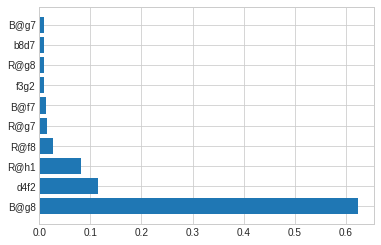

In [32]:
plot_moves_with_prob(legal_moves, a, only_top_x=10)

2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos


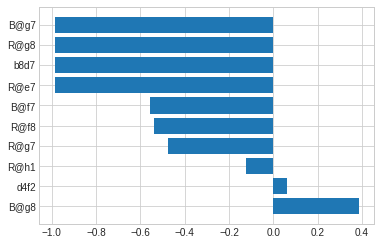

In [33]:
plot_moves_with_prob(legal_moves, mcts_agent.root_node.q, only_top_x=10)

2019-01-11 01:09:10 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos


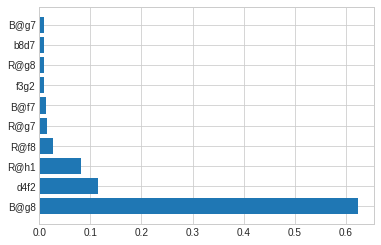

In [34]:
plot_moves_with_prob(legal_moves, c, only_top_x=10)

2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos


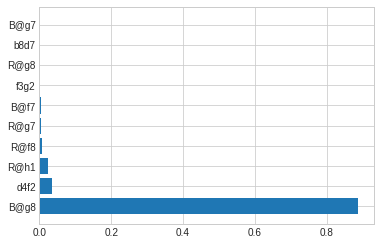

In [35]:
plot_moves_with_prob(legal_moves, p_vec_small, only_top_x=10)

2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos
2019-01-11 01:09:11 matplotlib.axes._base[21494] DEBUG update_title_pos


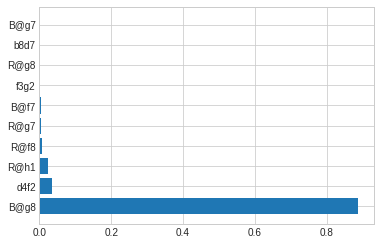

In [36]:
plot_moves_with_prob(legal_moves, p_vec_small, only_top_x=10)

In [37]:


%load_ext line_profiler
r = %lprun -r -f mcts_agent._run_single_playout mcts_agent._run_single_playout(state, mcts_agent.root_node)
r.print_stats()



Timer unit: 1e-06 s

Total time: 0.011213 s
File: ../../../DeepCrazyhouse/src/domain/agent/player/MCTSAgent.py
Function: _run_single_playout at line 754

Line #      Hits         Time  Per Hit   % Time  Line Contents
   754                                               def _run_single_playout(self, state: GameState, parent_node: Node, pipe_id=0, depth=1, chosen_nodes=[]):
   755                                                   """
   756                                                   This function works recursively until a leaf or terminal node is reached.
   757                                                   It ends by backpropagating the value of the new expanded node or by propagating the value of a terminal state.
   758                                           
   759                                                   :param state_: Current game-state for the evaluation. This state differs between the treads
   760                                                   :param pa

In [38]:
from DeepCrazyhouse.src.domain.crazyhouse.input_representation import board_to_planes


In [39]:
%load_ext line_profiler
r = %lprun -r -f board_to_planes board_to_planes(board)
r.print_stats()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Timer unit: 1e-06 s

Total time: 0.00062 s
File: ../../../DeepCrazyhouse/src/domain/crazyhouse/input_representation.py
Function: board_to_planes at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                           def board_to_planes(board, board_occ=0, normalize=True):
    28                                               """
    29                                               Gets the plane representation of a given board state.
    30                                               (Now history of past board positions is used.)
    31                                           
    32                                               ## Crazyhouse:
    33                                           
    34                                               Feature | Planes
    35                                           
    36                      

In [40]:
%load_ext line_profiler
r = %lprun -r -f board_to_planes board_to_planes(board)
r.print_stats()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Timer unit: 1e-06 s

Total time: 0.000573 s
File: ../../../DeepCrazyhouse/src/domain/crazyhouse/input_representation.py
Function: board_to_planes at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                           def board_to_planes(board, board_occ=0, normalize=True):
    28                                               """
    29                                               Gets the plane representation of a given board state.
    30                                               (Now history of past board positions is used.)
    31                                           
    32                                               ## Crazyhouse:
    33                                           
    34                                               Feature | Planes
    35                                           
    36                     